In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
from os import listdir
import pathlib
from random import randint
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import tensorflow_addons as tfa
from keras.utils import load_img,img_to_array
from keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import MaxPooling2D,Dropout,Dense,Input,Conv2D,Flatten,Conv2DTranspose
from keras.layers import GlobalAveragePooling2D,MaxPool2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

In [ ]:
folder = r'D:\5 class alziemers\Alzheimers-ADNI\train'
folder_path = pathlib.Path(folder)

In [ ]:
for file in listdir(folder):
    print(file)

Final AD JPEG
Final CN JPEG
Final EMCI JPEG
Final LMCI JPEG
Final MCI JPEG


In [ ]:
# counting the number of images in each category
for file in listdir(folder):
    i =0
    for image in listdir(folder + '/'+file):
        i = i +1
    print(file , i)

Final AD JPEG 145
Final CN JPEG 493
Final EMCI JPEG 204
Final LMCI JPEG 61
Final MCI JPEG 198


In [ ]:
# Creating the image datagenerator to have more samples
IMG_SIZE = 128
DIM = (IMG_SIZE, IMG_SIZE)

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from PIL import Image

# Define the root directory
root_directory = r'D:\5 class alziemers\Alzheimers-ADNI\train'

# Define the class labels and their respective folder names
class_labels = ['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']

# Define the augmentation settings
datagen = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.5, 1.5)
)

# Define the target size of the images
SIZE = 224

# Iterate over each class label
for label in class_labels:
    # Define the directory path for the current class label
    class_directory = os.path.join(root_directory, label)

    # Define the output directory for augmented images
    augmented_directory = os.path.join(root_directory, 'Augmented', label)
    os.makedirs(augmented_directory, exist_ok=True)

    # Collect the list of image files in the class directory
    image_files = [
        os.path.join(class_directory, file)
        for file in os.listdir(class_directory)
        if file.lower().endswith('.jpg')
    ]

    # Load and augment the images
    dataset = []
    for image_file in image_files:
        image = Image.open(image_file)
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))

    x = np.array(dataset)

    # Reshape the input to have a rank of 4
    x = np.expand_dims(x, axis=3)

    # Generate augmented images and save them
    i = 0
    for batch in datagen.flow(x, batch_size=16, save_to_dir=augmented_directory, save_prefix='augmented', save_format='jpg'):
        i += 1
        if i > 50:
            break

    print(f"Augmentation completed for {label}")

print("Data augmentation completed.")


Augmentation completed for Final AD JPEG
Augmentation completed for Final CN JPEG
Augmentation completed for Final EMCI JPEG
Augmentation completed for Final LMCI JPEG
Augmentation completed for Final MCI JPEG
Data augmentation completed.


In [ ]:
class_labels = ['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']
root_directory = r'D:\5 class alziemers\Alzheimers-ADNI\train'


In [ ]:
# Count the total number of augmented images and images for each class label
total_augmented_images = 0
class_counts = {}

# Iterate over each class label
for label in class_labels:
    augmented_folder_path = os.path.join(root_directory, 'Augmented', label)
    #print(augmented_folder_path)
    num_images = len(os.listdir(augmented_folder_path))
    total_augmented_images += num_images
    class_counts[label] = num_images

# Print the total number of augmented images and images for each class label
print(f"Total Augmented Images: {total_augmented_images}")
for label, count in class_counts.items():
    print(f"{label}: {count}")


Total Augmented Images: 3924
Final AD JPEG: 741
Final CN JPEG: 813
Final EMCI JPEG: 804
Final LMCI JPEG: 780
Final MCI JPEG: 786


In [ ]:
folder=r'D:\5 class alziemers\Alzheimers-ADNI\train\Augmented'
train_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM,
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
train_data_gen = train_generator.flow_from_directory(directory=folder, target_size=DIM, batch_size=6500, shuffle=False)

Found 3924 images belonging to 5 classes.


In [ ]:
import cv2
import os
import glob
import numpy as np

# set paths to the directory containing the images
train_dir = r'D:\5 class alziemers\Alzheimers-ADNI\train\Augmented'
test_dir = r'D:\5 class alziemers\Alzheimers-ADNI\test'

# define function to read and preprocess images from directory
def read_images_from_dir(directory):
    images = []
    labels = []
    for class_label in os.listdir(directory):
        class_path = os.path.join(directory, class_label)
        if os.path.isdir(class_path):
            for file_name in glob.glob(os.path.join(class_path, '*.jpg')):
                image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (256, 256)) # resize to common size
                images.append(image)
                labels.append(class_label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# read and preprocess images and labels from train, test, and validation directories
X_train, y_train = read_images_from_dir(train_dir)
X_test, y_test = read_images_from_dir(test_dir)

# print shapes of the loaded images and labels
print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train images shape: (3924, 256, 256)
Train labels shape: (3924,)
Test images shape: (195, 256, 256)
Test labels shape: (195,)


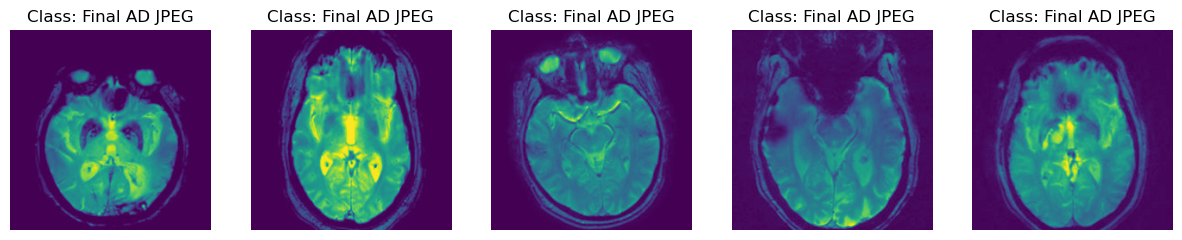

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
num_samples = 5  # number of samples to display
random_indices = np.random.randint(0, len(X_test), num_samples)
plt.figure(figsize=(15,5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(X_train[idx])
    plt.title('Class: {}'.format(y_train[idx]))
    plt.axis('off')
plt.show()

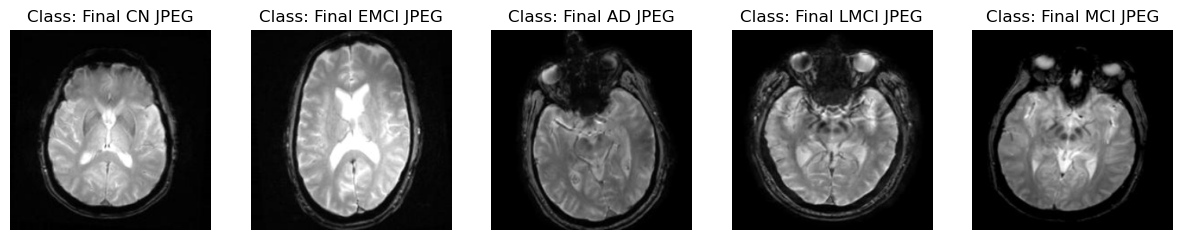

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Display some sample grayscale images with their class labels
num_samples = 5  # number of samples to display
random_indices = np.random.randint(0, len(X_train), num_samples)
plt.figure(figsize=(15,5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title('Class: {}'.format(y_train[idx]))
    plt.axis('off')
plt.show()

In [ ]:
test_folder=r'D:\5 class alziemers\Alzheimers-ADNI\test'
test_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM,
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
test_data_gen = train_generator.flow_from_directory(directory=test_folder, target_size=DIM, batch_size=6500, shuffle=False)

Found 195 images belonging to 5 classes.


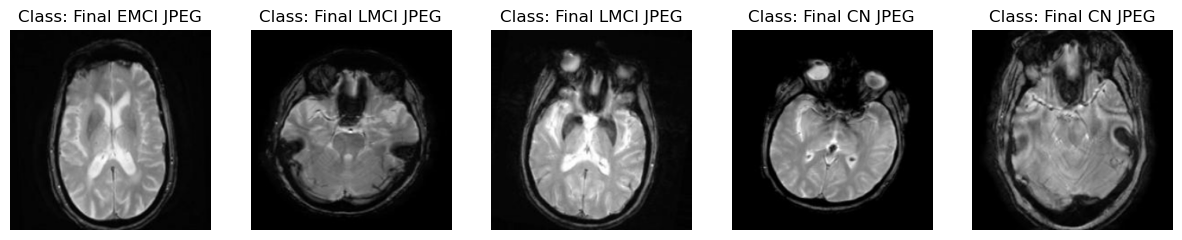

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Display some sample grayscale images with their class labels
num_samples = 5  # number of samples to display
random_indices = np.random.randint(0, len(X_train), num_samples)
plt.figure(figsize=(15,5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title('Class: {}'.format(y_train[idx]))
    plt.axis('off')
plt.show()

In [ ]:
train_data, train_labels = train_data_gen.next()

In [ ]:
test_data, test_labels = test_data_gen.next()

In [ ]:
train_data.shape, train_labels.shape

((3924, 128, 128, 3), (3924, 5))

In [ ]:
test_data.shape, test_labels.shape

((195, 128, 128, 3), (195, 5))

In [ ]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

print(train_data.shape, train_labels.shape)

(4065, 49152) (4065, 5)


In [ ]:
"""Did not ran
sm = SMOTE(random_state=42)

test_data, test_labels = sm.fit_resample(test_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), test_labels)

print(test_data.shape, test_labels.shape)
"""

(435, 49152) (435, 5)


In [ ]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(4065, 128, 128, 3) (4065, 5)


In [ ]:
test_data = test_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(test_data.shape, test_labels.shape)

(195, 128, 128, 3) (195, 5)


In [ ]:
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
#print(val_data.shape, val_labels.shape)

(4065, 128, 128, 3) (4065, 5)
(195, 128, 128, 3) (195, 5)


In [ ]:
# Defining convolutional blocks
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())

    return block

In [ ]:
# defining dense blocks
def dense_block(units, dropout_rate, act='relu'):
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

In [ ]:
IMAGE_SIZE = [128,128]
act = 'relu'

In [ ]:
model = Sequential([
    Input(shape=(*IMAGE_SIZE, 3)),
    Conv2D(32, 3, activation='relu', padding='same'),
    Conv2D(32, 3, activation='relu', padding='same'),
    MaxPool2D(),
    conv_block(64),
    conv_block(128),
    conv_block(256),
    MaxPool2D(),
    Dropout(0.2),
    conv_block(512),
    Dropout(0.25),
    Flatten(),
    dense_block(1024, 0.3),
    dense_block(512, 0.3),
    Dense(5, activation='softmax')
], name="cnn_model")


In [ ]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=5)]

model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 32, 32, 64)        55680     
                                                                 
 sequential_1 (Sequential)   (None, 16, 16, 128)       221952    
                                                                 
 sequential_2 (Sequential)   (None, 8, 8, 256)         886272    
                                                         

In [ ]:
CALLBACKS = [
    EarlyStopping(monitor='accuracy', min_delta=0.01, patience=5, mode='max')
]

In [ ]:
EPOCHS = 45

history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=EPOCHS)

Epoch 1/45
128/128 [==============================] - 159s 1s/step - loss: 2.0883 - acc: 0.2091 - auc: 0.5024 - f1_score: 0.2090 - val_loss: 3.4829 - val_acc: 0.4462 - val_auc: 0.6104 - val_f1_score: 0.1234
Epoch 2/45
128/128 [==============================] - 149s 1s/step - loss: 1.8567 - acc: 0.2276 - auc: 0.5213 - f1_score: 0.2267 - val_loss: 2.5966 - val_acc: 0.1846 - val_auc: 0.6335 - val_f1_score: 0.0662
Epoch 3/45
128/128 [==============================] - 157s 1s/step - loss: 1.8271 - acc: 0.2153 - auc: 0.5197 - f1_score: 0.2153 - val_loss: 4.7502 - val_acc: 0.1744 - val_auc: 0.4892 - val_f1_score: 0.0610
Epoch 4/45
128/128 [==============================] - 143s 1s/step - loss: 1.7789 - acc: 0.2418 - auc: 0.5477 - f1_score: 0.2410 - val_loss: 4.7615 - val_acc: 0.1795 - val_auc: 0.6025 - val_f1_score: 0.0609
Epoch 5/45
128/128 [==============================] - 140s 1s/step - loss: 1.7070 - acc: 0.2458 - auc: 0.5624 - f1_score: 0.2455 - val_loss: 1.9165 - val_acc: 0.2308 - val_

In [ ]:
test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

1/1 [==============================] - 0s 294ms/step - loss: 0.6799 - acc: 0.8621 - auc: 0.9523 - f1_score: 0.8148
Testing Accuracy: 86.21%


In [ ]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=30)
print("Train size",train_data.shape, train_labels.shape)
print("test size",test_data.shape, test_labels.shape)


Train size (1064, 128, 128, 3) (1064, 5)
test size (267, 128, 128, 3) (267, 5)


In [ ]:
model.save("model2_alziemers.h5")
model_path = "model2_alziemers.h5"

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pathlib
from beecolpy import abc

# Define the search space for ABC
search_space = {
    'learning_rate': {'type': 'float', 'min': 0.0001, 'max': 0.1},
    'dropout_rate': {'type': 'float', 'min': 0.2, 'max': 0.5},
    'epochs': {'type': 'int', 'min': 20, 'max': 50},
    'batch_size': {'type': 'int', 'min': 16, 'max':128}
}

# Define the boundaries for ABC
boundaries = [
    [search_space['learning_rate']['min'], search_space['learning_rate']['max']],
    [search_space['dropout_rate']['min'], search_space['dropout_rate']['max']],
    [search_space['epochs']['min'], search_space['epochs']['max']],
    [search_space['batch_size']['min'], search_space['batch_size']['max']]
]


In [ ]:
def fitness_function(x):
    # convert the ABC search space to model hyperparameters
    params = {
        'learning_rate': x[0],
        'dropout_rate': x[1],
        'epochs': int(x[2]),
        'batch_size': int(x[3])
    }

    print('Learning Rate:{},Dropout Rate:{},Epochs:{}'.format(params['learning_rate'],params['dropout_rate'], params['epochs']))

    def build_model(input_shape=(128, 128, 3), learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate']):
        model = Sequential([
            Input(shape=(*IMAGE_SIZE, 3)),
            Conv2D(32, 3, activation='relu', padding='same'),
            Conv2D(32, 3, activation='relu', padding='same'),
            MaxPool2D(),
            conv_block(64),
            conv_block(128),
            conv_block(256),
            MaxPool2D(),
            Dropout(dropout_rate),
            conv_block(512),
            Dropout(dropout_rate),
            Flatten(),
            dense_block(1024, 0.4),
            dense_block(512, 0.4),
            Dense(5, activation='softmax')
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        model.fit(
            train_data,
            train_labels,
            epochs=params['epochs'],
            validation_data=(test_data, test_labels),
            batch_size=params['batch_size'],
            callbacks=[
                keras.callbacks.EarlyStopping(patience=3),
                keras.callbacks.LambdaCallback(
                    on_epoch_end=lambda epoch, logs: logs['val_accuracy'] >= 0.9 and setattr(model, 'stop_training', True)
                )
            ]
        )

        loss, accuracy = model.evaluate(test_data)
        print('Test accuracy:', accuracy)
        return accuracy

    accuracy = build_model()
    return -accuracy


In [ ]:
abc_optimizer = abc(fitness_function, boundaries)
abc_optimizer.fit() #Execute the algorithm

solution = abc_optimizer.get_solution()
print(solution)


Learning Rate:0.014700040119932917,Dropout Rate:0.37532744939663154,Epochs:37
Epoch 1/37
16/16 [==============================] - 32s 2s/step - loss: 3.0331 - accuracy: 0.1955 - val_loss: 113959.6016 - val_accuracy: 0.2022
Epoch 2/37
16/16 [==============================] - 32s 2s/step - loss: 2.2790 - accuracy: 0.2246 - val_loss: 2629.0588 - val_accuracy: 0.1910
Epoch 3/37
16/16 [==============================] - 31s 2s/step - loss: 2.1151 - accuracy: 0.2246 - val_loss: 495.8409 - val_accuracy: 0.1685
Epoch 4/37
16/16 [==============================] - 32s 2s/step - loss: 2.1162 - accuracy: 0.1927 - val_loss: 39.6727 - val_accuracy: 0.2022
Epoch 5/37
16/16 [==============================] - 33s 2s/step - loss: 2.0761 - accuracy: 0.1927 - val_loss: 41.3206 - val_accuracy: 0.1985
Epoch 6/37
16/16 [==============================] - 32s 2s/step - loss: 1.9952 - accuracy: 0.2199 - val_loss: 39.0237 - val_accuracy: 0.1985
Epoch 7/37
16/16 [==============================] - 33s 2s/step - los

15/15 [==============================] - 33s 2s/step - loss: 1.8870 - accuracy: 0.2077 - val_loss: 9.1889 - val_accuracy: 0.2434
Epoch 14/36
15/15 [==============================] - 33s 2s/step - loss: 1.8747 - accuracy: 0.2162 - val_loss: 6.8442 - val_accuracy: 0.1910
Epoch 15/36
15/15 [==============================] - 33s 2s/step - loss: 1.8369 - accuracy: 0.2124 - val_loss: 3.9901 - val_accuracy: 0.1610
Epoch 16/36
15/15 [==============================] - 33s 2s/step - loss: 1.7917 - accuracy: 0.2293 - val_loss: 3.6767 - val_accuracy: 0.1760
Epoch 17/36
15/15 [==============================] - 33s 2s/step - loss: 1.8302 - accuracy: 0.2209 - val_loss: 2.1406 - val_accuracy: 0.1985
Epoch 18/36
15/15 [==============================] - 35s 2s/step - loss: 1.6867 - accuracy: 0.2444 - val_loss: 1.9812 - val_accuracy: 0.2022
Epoch 19/36
15/15 [==============================] - 35s 2s/step - loss: 1.7194 - accuracy: 0.2293 - val_loss: 2.3770 - val_accuracy: 0.2060
Epoch 20/36
15/15 [======

20/20 [==============================] - 37s 2s/step - loss: 8.4875 - accuracy: 0.2011 - val_loss: 65311.3320 - val_accuracy: 0.1685
Epoch 2/31
20/20 [==============================] - 35s 2s/step - loss: 3.9770 - accuracy: 0.1701 - val_loss: 3044.9910 - val_accuracy: 0.1910
Epoch 3/31
20/20 [==============================] - 34s 2s/step - loss: 2.6955 - accuracy: 0.1739 - val_loss: 788.0714 - val_accuracy: 0.2022
Epoch 4/31
20/20 [==============================] - 36s 2s/step - loss: 2.3069 - accuracy: 0.1729 - val_loss: 1240.9203 - val_accuracy: 0.2022
Epoch 5/31
20/20 [==============================] - 34s 2s/step - loss: 2.4028 - accuracy: 0.2002 - val_loss: 95.5677 - val_accuracy: 0.2022
Epoch 6/31
20/20 [==============================] - 35s 2s/step - loss: 1.9740 - accuracy: 0.2086 - val_loss: 128.8948 - val_accuracy: 0.2172
Epoch 7/31
20/20 [==============================] - 35s 2s/step - loss: 1.8482 - accuracy: 0.2049 - val_loss: 55.8492 - val_accuracy: 0.1948
Epoch 8/31
20/2

12/12 [==============================] - 36s 3s/step - loss: 2.6560 - accuracy: 0.1908 - val_loss: 116.6827 - val_accuracy: 0.1685
Epoch 2/29
12/12 [==============================] - 32s 3s/step - loss: 2.2960 - accuracy: 0.2143 - val_loss: 128.9188 - val_accuracy: 0.2022
Epoch 3/29
12/12 [==============================] - 31s 3s/step - loss: 2.1781 - accuracy: 0.2096 - val_loss: 45.0260 - val_accuracy: 0.2022
Epoch 4/29
12/12 [==============================] - 31s 3s/step - loss: 2.0136 - accuracy: 0.2096 - val_loss: 15.5560 - val_accuracy: 0.2022
Epoch 5/29
12/12 [==============================] - 30s 2s/step - loss: 1.9238 - accuracy: 0.2143 - val_loss: 4.2334 - val_accuracy: 0.2022
Epoch 6/29
12/12 [==============================] - 32s 3s/step - loss: 1.9716 - accuracy: 0.1805 - val_loss: 6.9579 - val_accuracy: 0.2022
Epoch 7/29
12/12 [==============================] - 31s 3s/step - loss: 1.8661 - accuracy: 0.2068 - val_loss: 4.9671 - val_accuracy: 0.1910
Epoch 8/29
9/9 [=========

Epoch 13/37
13/13 [==============================] - 32s 2s/step - loss: 1.7039 - accuracy: 0.1992 - val_loss: 1.6336 - val_accuracy: 0.2472
Epoch 14/37
13/13 [==============================] - 33s 3s/step - loss: 1.6556 - accuracy: 0.2274 - val_loss: 1.6325 - val_accuracy: 0.1910
Epoch 15/37
13/13 [==============================] - 34s 3s/step - loss: 1.6746 - accuracy: 0.2086 - val_loss: 1.6309 - val_accuracy: 0.2285
Epoch 16/37
13/13 [==============================] - 1424s 118s/step - loss: 1.6375 - accuracy: 0.2115 - val_loss: 1.6233 - val_accuracy: 0.1948
Epoch 17/37
13/13 [==============================] - 31s 2s/step - loss: 1.6645 - accuracy: 0.2199 - val_loss: 1.6454 - val_accuracy: 0.2397
Epoch 18/37
13/13 [==============================] - 30s 2s/step - loss: 1.6264 - accuracy: 0.2368 - val_loss: 1.5903 - val_accuracy: 0.2285
Epoch 19/37
13/13 [==============================] - 31s 2s/step - loss: 1.6196 - accuracy: 0.2331 - val_loss: 1.6161 - val_accuracy: 0.2022
Epoch 20/

Epoch 9/46
15/15 [==============================] - 35s 2s/step - loss: 1.7026 - accuracy: 0.2105 - val_loss: 46.9543 - val_accuracy: 0.1910
Epoch 10/46
15/15 [==============================] - 35s 2s/step - loss: 1.7134 - accuracy: 0.2086 - val_loss: 20.7642 - val_accuracy: 0.1985
Epoch 11/46
15/15 [==============================] - 36s 2s/step - loss: 1.7436 - accuracy: 0.2096 - val_loss: 37.6367 - val_accuracy: 0.1685
Epoch 12/46
15/15 [==============================] - 34s 2s/step - loss: 1.7548 - accuracy: 0.1870 - val_loss: 11.5209 - val_accuracy: 0.2022
Epoch 13/46
15/15 [==============================] - 35s 2s/step - loss: 1.7012 - accuracy: 0.2030 - val_loss: 5.3022 - val_accuracy: 0.2472
Epoch 14/46
15/15 [==============================] - 36s 2s/step - loss: 1.7041 - accuracy: 0.1908 - val_loss: 9.0367 - val_accuracy: 0.1985
Epoch 15/46
15/15 [==============================] - 36s 2s/step - loss: 1.6797 - accuracy: 0.1889 - val_loss: 3.2638 - val_accuracy: 0.2060
Epoch 16/4